In [1]:
pip install pandas numpy matplotlib sklearn tensorflow transformers keras


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Step 1: Load and Prepare Data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer

stock_data = pd.read_csv("stock_f.csv")
news_data = pd.read_csv("news_f.csv", encoding='latin-1')

merged_data = pd.merge(stock_data, news_data, on="Date", how="inner")
merged_data.dropna(inplace=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_headlines = [tokenizer.encode(text, add_special_tokens=True, max_length=128, truncation=True) for text in merged_data['headlines']]

max_length = 128
from keras.preprocessing.sequence import pad_sequences
X_lstm = pad_sequences(tokenized_headlines, maxlen=max_length, dtype='int32', padding='post')
y_lstm = merged_data['Close'].values

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Step 2: Train LSTM Model

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.vocab), output_dim=128, input_length=max_length))
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
2/2 [==============================] - 11s 3s/step - loss: 26505.3262 - val_loss: 26246.6641
Epoch 2/10
2/2 [==============================] - 1s 341ms/step - loss: 26465.7930 - val_loss: 26194.5176
Epoch 3/10
2/2 [==============================] - 1s 559ms/step - loss: 26409.9492 - val_loss: 26103.3574
Epoch 4/10
2/2 [==============================] - 1s 473ms/step - loss: 26308.7129 - val_loss: 25935.0625
Epoch 5/10
2/2 [==============================] - 1s 429ms/step - loss: 26128.7285 - val_loss: 25657.4121
Epoch 6/10
2/2 [==============================] - 1s 552ms/step - loss: 25848.0371 - val_loss: 25326.0547
Epoch 7/10
2/2 [==============================] - 1s 488ms/step - loss: 25508.9355 - val_loss: 25054.9199
Epoch 8/10
2/2 [==============================] - 1s 422ms/step - loss: 25265.9766 - val_loss: 24839.9355
Epoch 9/10
2/2 [==============================] - 1s 424ms/step - loss: 25048.2148 - val_loss: 24654.0938
Epoch 10/10
2/2 [==============================]

Step 3: Obtain BERT Embeddings

In [4]:
from transformers import TFBertModel
import tensorflow as tf
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_embeddings = bert_model.predict(X_test)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

1/1 [==============================] - 29s 29s/step


Step 4: Combine LSTM and BERT Models

In [5]:
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

print(type(bert_embeddings))
print(dir(bert_embeddings))
bert_embeddings_last_hidden_state = bert_embeddings.last_hidden_state

bert_embeddings_reshaped = tf.reshape(bert_embeddings_last_hidden_state, (-1, bert_embeddings_last_hidden_state.shape[-1]))

input1 = Input(shape=(bert_embeddings_reshaped.shape[1],))
input2 = Input(shape=(X_lstm.shape[1],))
concatenated = Concatenate()([input1, input2])
dense_layer = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='linear')(dense_layer)

model = Model(inputs=[input1, input2], outputs=output)

model.compile(loss='mean_squared_error', optimizer='adam')



<class 'transformers.modeling_tf_outputs.TFBaseModelOutputWithPoolingAndCrossAttentions'>
['__annotations__', '__class__', '__class_getitem__', '__contains__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__or__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'attentions', 'clear', 'copy', 'cross_attentions', 'fromkeys', 'get', 'hidden_states', 'items', 'keys', 'last_hidden_state', 'move_to_end', 'past_key_values', 'pooler_output', 'pop', 'popitem', 'setdefault', 'to_tuple', 'update', 'values']


In [6]:
print(f"X_lstm shape: {X_lstm.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"bert_embeddings_reshaped shape: {bert_embeddings_reshaped.shape}")

X_lstm shape: (59, 128)
y_train shape: (47,)
bert_embeddings_reshaped shape: (1536, 768)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [8]:
print(X_lstm.shape)
print(y_train.shape)

(59, 128)
(47,)


In [9]:
import numpy as np
y_train_2d = np.reshape(y_train, (-1, 1))
print("Original shape of y_train:", y_train.shape)
print("Reshaped shape of y_train:", y_train_2d.shape)


Original shape of y_train: (47,)
Reshaped shape of y_train: (47, 1)


In [10]:
print(X_lstm.shape)
print(y_train_2d.shape)

(59, 128)
(47, 1)


In [11]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

stock_data = pd.read_csv("stock_f.csv")
news_data = pd.read_csv("news_f.csv", encoding='latin-1')

merged_data = pd.merge(stock_data, news_data, on="Date", how="inner")
merged_data.dropna(inplace=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_headlines = [tokenizer.encode(text, add_special_tokens=True, max_length=128, truncation=True) for text in merged_data['headlines']]

max_length = 128
X_lstm = pad_sequences(tokenized_headlines, maxlen=max_length, dtype='int32', padding='post')

if X_lstm.shape[0] == 0:
    raise ValueError("X_lstm is empty. Check your data or preprocessing steps.")
y_train = merged_data['Close'].values
print("Shape of X_lstm:", X_lstm.shape)
print(X_lstm)

Shape of X_lstm: (59, 128)
[[  101  6207  4895 ...     0     0     0]
 [  101  6207  4311 ...     0     0     0]
 [  101  6207  5344 ...     0     0     0]
 ...
 [  101  6207 18989 ...     0     0     0]
 [  101  6207  5344 ...     0     0     0]
 [  101  6207  4311 ...     0     0     0]]


--------------------------------------------------------------------------------

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
2/2 [==============================] - 1s 158ms/step - loss: 13408.2871 - val_loss: 3287.0247
Epoch 2/10
2/2 [==============================] - 0s 39ms/step - loss: 3203.8179 - val_loss: 11247.8213
Epoch 3/10
2/2 [==============================] - 0s 39ms/step - loss: 5396.5068 - val_loss: 5774.8687
Epoch 4/10
2/2 [==============================] - 0s 40ms/step - loss: 3995.4336 - val_loss: 3507.6833
Epoch 5/10
2/2 [==============================] - 0s 39ms/step - loss: 3743.7866 - val_loss: 1610.9370
Epoch 6/10
2/2 [==============================] - 0s 39ms/step - loss: 1016.0839 - val_loss: 4507.0884
Epoch 7/10
2/2 [==============================] - 0s 38ms/step - loss: 2062.4285 - val_loss: 3355.5989
Epoch 8/10
2/2 [==============================] - 0s 39ms/step - loss: 1583.7979 - val_loss: 1314.1495
Epoch 9/10
2/2 [==============================] - 0s 40ms/step - loss: 1392.0713 - val_loss: 1218.3334
Epoch 10/10
2/2 [==============================] - 0s 43ms/step - loss

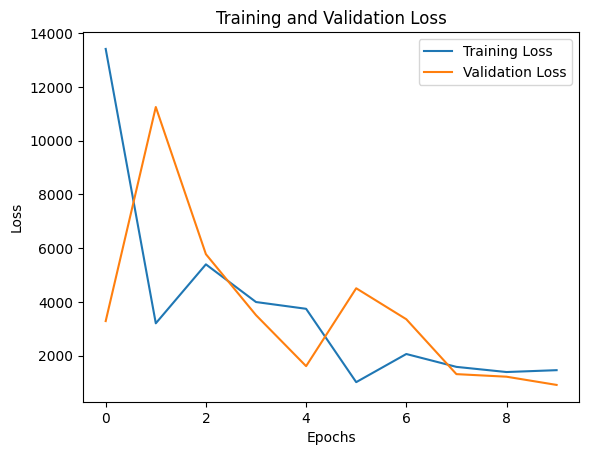

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, Concatenate, Dense
from keras.models import Model
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel
stock_data = pd.read_csv("stock_f.csv")
news_data = pd.read_csv("news_f.csv", encoding='latin-1')

merged_data = pd.merge(stock_data, news_data, on="Date", how="inner")
merged_data.dropna(inplace=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_headlines = [tokenizer.encode(text, add_special_tokens=True, max_length=128, truncation=True) for text in merged_data['headlines']]

max_length = 128
X_lstm = pad_sequences(tokenized_headlines, maxlen=max_length, dtype='int32', padding='post')

if X_lstm.shape[0] == 0:
    raise ValueError("X_lstm is empty. Check your data or preprocessing steps.")

y_train = merged_data['Close'].values

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
headline_texts = [tokenizer.decode(tokens, skip_special_tokens=True) for tokens in tokenized_headlines]

bert_inputs = tokenizer(headline_texts, return_tensors="tf", padding=True, truncation=True)
bert_outputs = bert_model(bert_inputs)
bert_embeddings = bert_outputs.last_hidden_state.numpy()

headline_texts = [tokenizer.decode(tokens, skip_special_tokens=True) for tokens in tokenized_headlines]

bert_inputs = tokenizer(headline_texts, return_tensors="tf", padding=True, truncation=True)
bert_outputs = bert_model(bert_inputs)
bert_embeddings = bert_outputs.last_hidden_state.numpy()
headline_texts = [tokenizer.decode(tokens, skip_special_tokens=True) for tokens in X_lstm]

bert_inputs = tokenizer(headline_texts, return_tensors="tf", padding=True, truncation=True)
bert_outputs = bert_model(bert_inputs)
bert_embeddings = bert_outputs.last_hidden_state.numpy()

bert_embeddings_reshaped = np.reshape(bert_embeddings, (bert_embeddings.shape[0], -1))

input1 = Input(shape=(bert_embeddings_reshaped.shape[1],))
input2 = Input(shape=(X_lstm.shape[1],))
concatenated = Concatenate()([input1, input2])
dense_layer = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='linear')(dense_layer)

model = Model(inputs=[input1, input2], outputs=output)

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(x=[bert_embeddings_reshaped, X_lstm], y=y_train, epochs=10, batch_size=32, validation_split=0.2)

# Visualize training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [13]:
print("Number of samples in bert_embeddings_reshaped:", bert_embeddings_reshaped.shape[0])
print("Number of samples in X_test:", X_test.shape[0])

if bert_embeddings_reshaped.shape[0] != X_test.shape[0]:
    X_test = X_test[:bert_embeddings_reshaped.shape[0]]
    y_test = y_test[:bert_embeddings_reshaped.shape[0]]
print("Number of samples after adjustment:", X_test.shape[0])


Number of samples in bert_embeddings_reshaped: 59
Number of samples in X_test: 12
Number of samples after adjustment: 12


In [14]:
bert_embeddings_reshaped = bert_embeddings_reshaped[:X_test.shape[0]]
print("Number of samples after adjustment:", bert_embeddings_reshaped.shape[0])


Number of samples after adjustment: 12


In [15]:
print(bert_embeddings_reshaped)
print(X_test)


[[-0.3380484   0.08875677 -0.25788188 ...  0.09117049  0.01125895
  -0.44267887]
 [-0.20776936  0.3291252   0.07424775 ...  0.12455278 -0.06523275
   0.0383059 ]
 [-0.014601    0.25896555  0.072391   ...  0.17057884  0.11194839
   0.05818537]
 ...
 [-0.42028245  0.21321401 -0.01090472 ... -0.33441845 -0.49575755
  -0.2211853 ]
 [-0.18581028  0.03822874  0.09886339 ...  0.03867254  0.20081897
  -0.1925791 ]
 [-0.46827078  0.22525436 -0.26589322 ...  0.01309042 -0.06430396
   0.10204773]]
[[  101  6207  4895 ...     0     0     0]
 [  101  6207  5766 ...     0     0     0]
 [  101  6207 13999 ...     0     0     0]
 ...
 [  101  6207 17472 ...     0     0     0]
 [  101  6207  5344 ...     0     0     0]
 [  101  6207 20880 ...     0     0     0]]


1/1 [==============================] - 0s 128ms/step


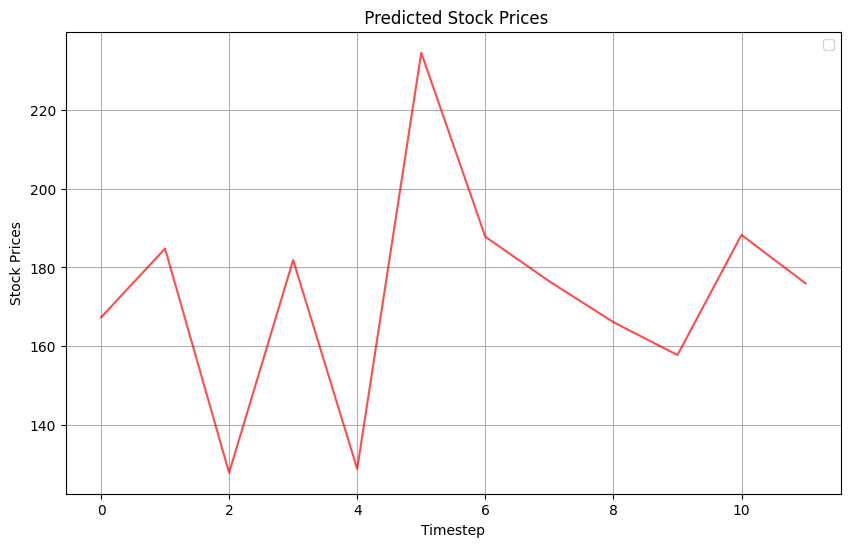

[[-0.3380484   0.08875677 -0.25788188 ...  0.09117049  0.01125895
  -0.44267887]
 [-0.20776936  0.3291252   0.07424775 ...  0.12455278 -0.06523275
   0.0383059 ]
 [-0.014601    0.25896555  0.072391   ...  0.17057884  0.11194839
   0.05818537]
 ...
 [-0.42028245  0.21321401 -0.01090472 ... -0.33441845 -0.49575755
  -0.2211853 ]
 [-0.18581028  0.03822874  0.09886339 ...  0.03867254  0.20081897
  -0.1925791 ]
 [-0.46827078  0.22525436 -0.26589322 ...  0.01309042 -0.06430396
   0.10204773]]
[[  101  6207  4895 ...     0     0     0]
 [  101  6207  5766 ...     0     0     0]
 [  101  6207 13999 ...     0     0     0]
 ...
 [  101  6207 17472 ...     0     0     0]
 [  101  6207  5344 ...     0     0     0]
 [  101  6207 20880 ...     0     0     0]]


In [16]:
predicted_prices = model.predict([bert_embeddings_reshaped, X_test])
plt.figure(figsize=(10, 6))
plt.plot(predicted_prices, color='red', alpha=0.7)

plt.xlabel('Timestep')
plt.ylabel('Stock Prices')
plt.title(' Predicted Stock Prices')
plt.legend()
plt.grid(True)
plt.show()
print(bert_embeddings_reshaped)
print(X_test)


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test, predicted_prices)
#print("Mean Squared Error (MSE):", mse)

mae = mean_absolute_error(y_test, predicted_prices)
print("Mean Absolute Error (MAE):", mae)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 25.486422856648762
Root Mean Squared Error (RMSE): 30.232659066989147


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Baseline Model: Predict using previous day's price
y_pred_baseline = X_test[:, -1]  # Assuming last token is the previous day's price

# Calculate MAE and RMSE for the baseline model
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)

# Your Model Predictions
predicted_prices = model.predict([bert_embeddings_reshaped, X_test])

# Calculate MAE and RMSE for your model
mae_model = mean_absolute_error(y_test, predicted_prices)
rmse_model = np.sqrt(mean_squared_error(y_test, predicted_prices))
r2_model = r2_score(y_test, predicted_prices)

#print(f"Baseline MAE: {mae_baseline}")
#print(f"Baseline RMSE: {rmse_baseline}")
#print(f"Baseline R2: {r2_baseline}")

#print(f"Your Model MAE: {mae_model}")
#print(f"Your Model RMSE: {rmse_model}")
#print(f"Your Model R2: {r2_model}")


1/1 [==============================] - 0s 42ms/step


In [ ]:
pip install tensorflow scikit-learn


In [ ]:
pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Function to create model, required for KerasRegressor
def create_model(optimizer='adam', dropout_rate=0.2, lstm_units=50):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.vocab), output_dim=128, input_length=max_length))
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Wrap the model using KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.4],
    'lstm_units': [50, 100, 150]
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=KFold(n_splits=3))

# Fit the grid search to the data
grid_result = grid.fit([bert_embeddings_train, X_train], y_train)

# Print the best parameters and best score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")

# Use the best estimator to predict
best_model = grid_result.best_estimator_
predicted_prices = best_model.predict([bert_embeddings_test, X_test])

# Evaluate performance
mae = mean_absolute_error(y_test, predicted_prices)
rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
r2 = r2_score(y_test, predicted_prices)

print(f"Improved Model MAE: {mae}")
print(f"Improved Model RMSE: {rmse}")
print(f"Improved Model R2: {r2}")


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
#plt.plot(y_test, label='Actual Prices', color='blue')
